## Data set preparation for ML model generation for WM apothecia prediction in irrigated environments


## Notes
* weather predictors and  principal components data don't include categorical data (soil, crop, spacing)
* look into reducing the number of categorical vars to increase number of weather vars

### Set up/check environment

In [3]:
# Check environment
!conda info
# active environment should be WM_ML


     active environment : base
    active env location : /opt/anaconda3
            shell level : 2
       user config file : /Users/jilliancheck/.condarc
 populated config files : /Users/jilliancheck/.condarc
          conda version : 24.11.3
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.11.3=0
                          __osx=15.3.2=0
                          __unix=0=0
       base environment : /opt/anaconda3  (writable)
      conda av data dir : /opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-arm64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/anaconda3/pkgs
               

In [4]:
# Import packages 
import pandas as pd
import random
import numpy as np
import sklearn
from sklearn import datasets
from datetime import datetime
from itertools import cycle
import glob2
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelBinarizer as lb

# set the number of maximum displayed rows for printed dataframes to 1000
pd.set_option('display.max_rows', 1000)

#### RTMA and SM/ST

### PCA
#### Identify most explanatory independent variables, reduce feature space size
#### How many principal components do we need? Which normalization method gives us the least needed of PCs?
* At what point does the explained variance % level off with increasing number of principal components?) OR how man PCs are needed to explain 85% variance? (aiming for explaining too much variance may lead to overfitting)
* Which rescaling method results in the most variance explained by least number of PCs?  
* Three methods: max absolute rescaling, min-max feature scaling, z-score

In [5]:
# enable matplotlib interactive
#import matplotlib.pyplot as plt
#%matplotlib notebook

#### Raw data

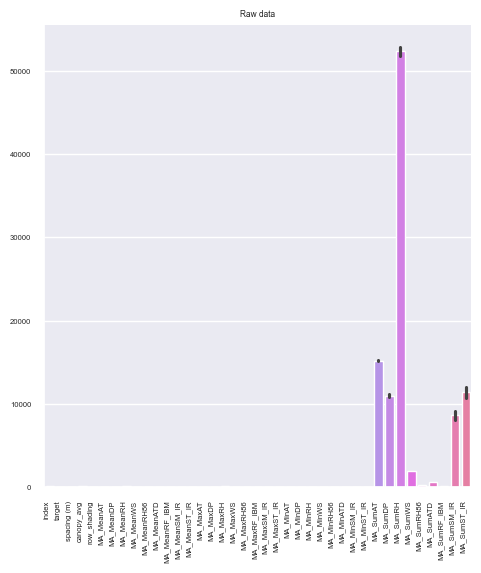

In [6]:
# plot raw data

PCA_df = pd.read_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/WM train test data Fall 24/RTMA_LX_23_df.csv')

# including 'row_shading instead of canopy closure and row spacing'
row_shading = PCA_df['canopy_avg'] * PCA_df['spacing (m)']
insert_index = PCA_df.columns.get_loc('canopy_avg') + 1  # Insert after col1
PCA_df.insert(insert_index, 'row_shading', row_shading)

sns.set_theme()
sns.set(font_scale=0.5) 
ax = sns.catplot(data=PCA_df, kind = 'bar')
ax.set_xticklabels(rotation=90, ha="right")
ax.set(title = 'Raw data')

# obviously major differences in scales

In [7]:
# dataset for PCA analysis - continuous predictors only, not the target variable or categorical predictors
display(PCA_df.iloc[:, 7:])

,row_shading,MA_MeanAT,MA_MeanDP,MA_MeanRH,MA_MeanWS,MA_MeanRH86,MA_MeanATD,MA_MeanRF_IBM,MA_MeanSM_IR,MA_MeanST_IR,...,MA_MinST_IR,MA_SumAT,MA_SumDP,MA_SumRH,MA_SumWS,MA_SumRH86,MA_SumATD,MA_SumRF_IBM,MA_SumSM_IR,MA_SumST_IR
0,36.81820,21.311806,16.241250,75.237500,2.089853,0.381944,0.788889,0.130278,13.555754,21.311371,...,20.255709,15344.5,11693.7,54171.0,1504.694444,275,568,93.8,3117.916742,4970.720308
1,37.07660,22.052639,16.547500,73.497083,2.072184,0.344444,0.718056,0.170556,13.678102,21.625430,...,20.623318,15877.9,11914.2,52917.9,1491.972222,248,517,122.8,5779.277750,9208.189375
2,47.20050,21.771667,16.786944,75.555556,2.747222,0.355556,0.781944,0.120278,13.357698,22.298266,...,21.468948,15675.6,12086.6,54400.0,1978.000000,256,563,86.6,791.432858,1333.557258
3,47.37390,20.734306,15.819861,75.873889,2.363272,0.377778,0.837500,0.107778,13.590111,21.337197,...,20.276167,14928.7,11390.3,54629.2,1701.555556,272,603,77.6,2934.870167,4677.423125
4,44.98710,21.710972,16.732222,75.667778,2.523187,0.356944,0.752778,0.095139,13.828215,21.699668,...,20.732416,15631.9,12047.2,54480.8,1816.694444,257,542,68.5,4805.097617,7620.721658
5,31.03860,21.432222,16.244861,75.053194,2.179012,0.375000,0.759722,0.083333,13.532176,21.682219,...,20.657335,15431.2,11696.3,54038.3,1568.888889,270,547,60.0,6058.521167,9746.280858
6,37.11460,21.381552,15.902886,74.059028,2.842785,0.374034,0.753804,0.352017,13.056430,21.107837,...,19.644900,15372.2,11433.2,53249.8,2042.694444,269,542,252.9,859.220905,1396.812033
7,37.20580,20.547941,15.576220,76.088333,2.986574,0.401812,0.820471,0.327156,12.128638,19.593673,...,18.599561,14772.0,11198.0,54710.9,2146.222222,289,590,235.0,2830.031130,4579.529300
8,37.81760,20.944028,16.940417,79.818472,3.014545,0.456944,0.798611,0.292083,11.674471,19.266711,...,18.278367,15079.7,12197.1,57469.3,2170.472222,329,575,210.3,4682.342042,7737.865750
9,37.36920,21.873056,17.417639,78.126111,2.793981,0.423611,0.763889,0.068750,11.639318,19.224757,...,18.268049,15748.6,12540.7,56250.8,2011.666667,305,550,49.5,6331.651940,10469.211458


#### Max absolute rescaling

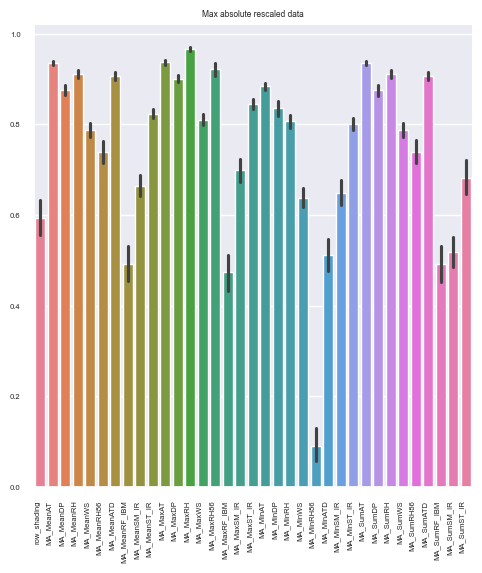

In [8]:
# Copy the data - only the numerical data
dt_max_scaled = PCA_df.iloc[:, 7:]
    #Change back to 6: if not using row_shading!!!

# Apply normalization techniques
for column in dt_max_scaled.columns:
    dt_max_scaled[column] = dt_max_scaled[column]  / dt_max_scaled[column].abs().max()
      
# View normalized data
#display(dt_max_scaled)

# Plot normalized data
sns.set_theme()
sns.set(font_scale=0.5) 
ax = sns.catplot(data=dt_max_scaled, kind = 'bar')
ax.set_xticklabels(rotation=90, ha="right")
ax.set(title = 'Max absolute rescaled data')

Number of PCs needed to explain 90% of variance: 6


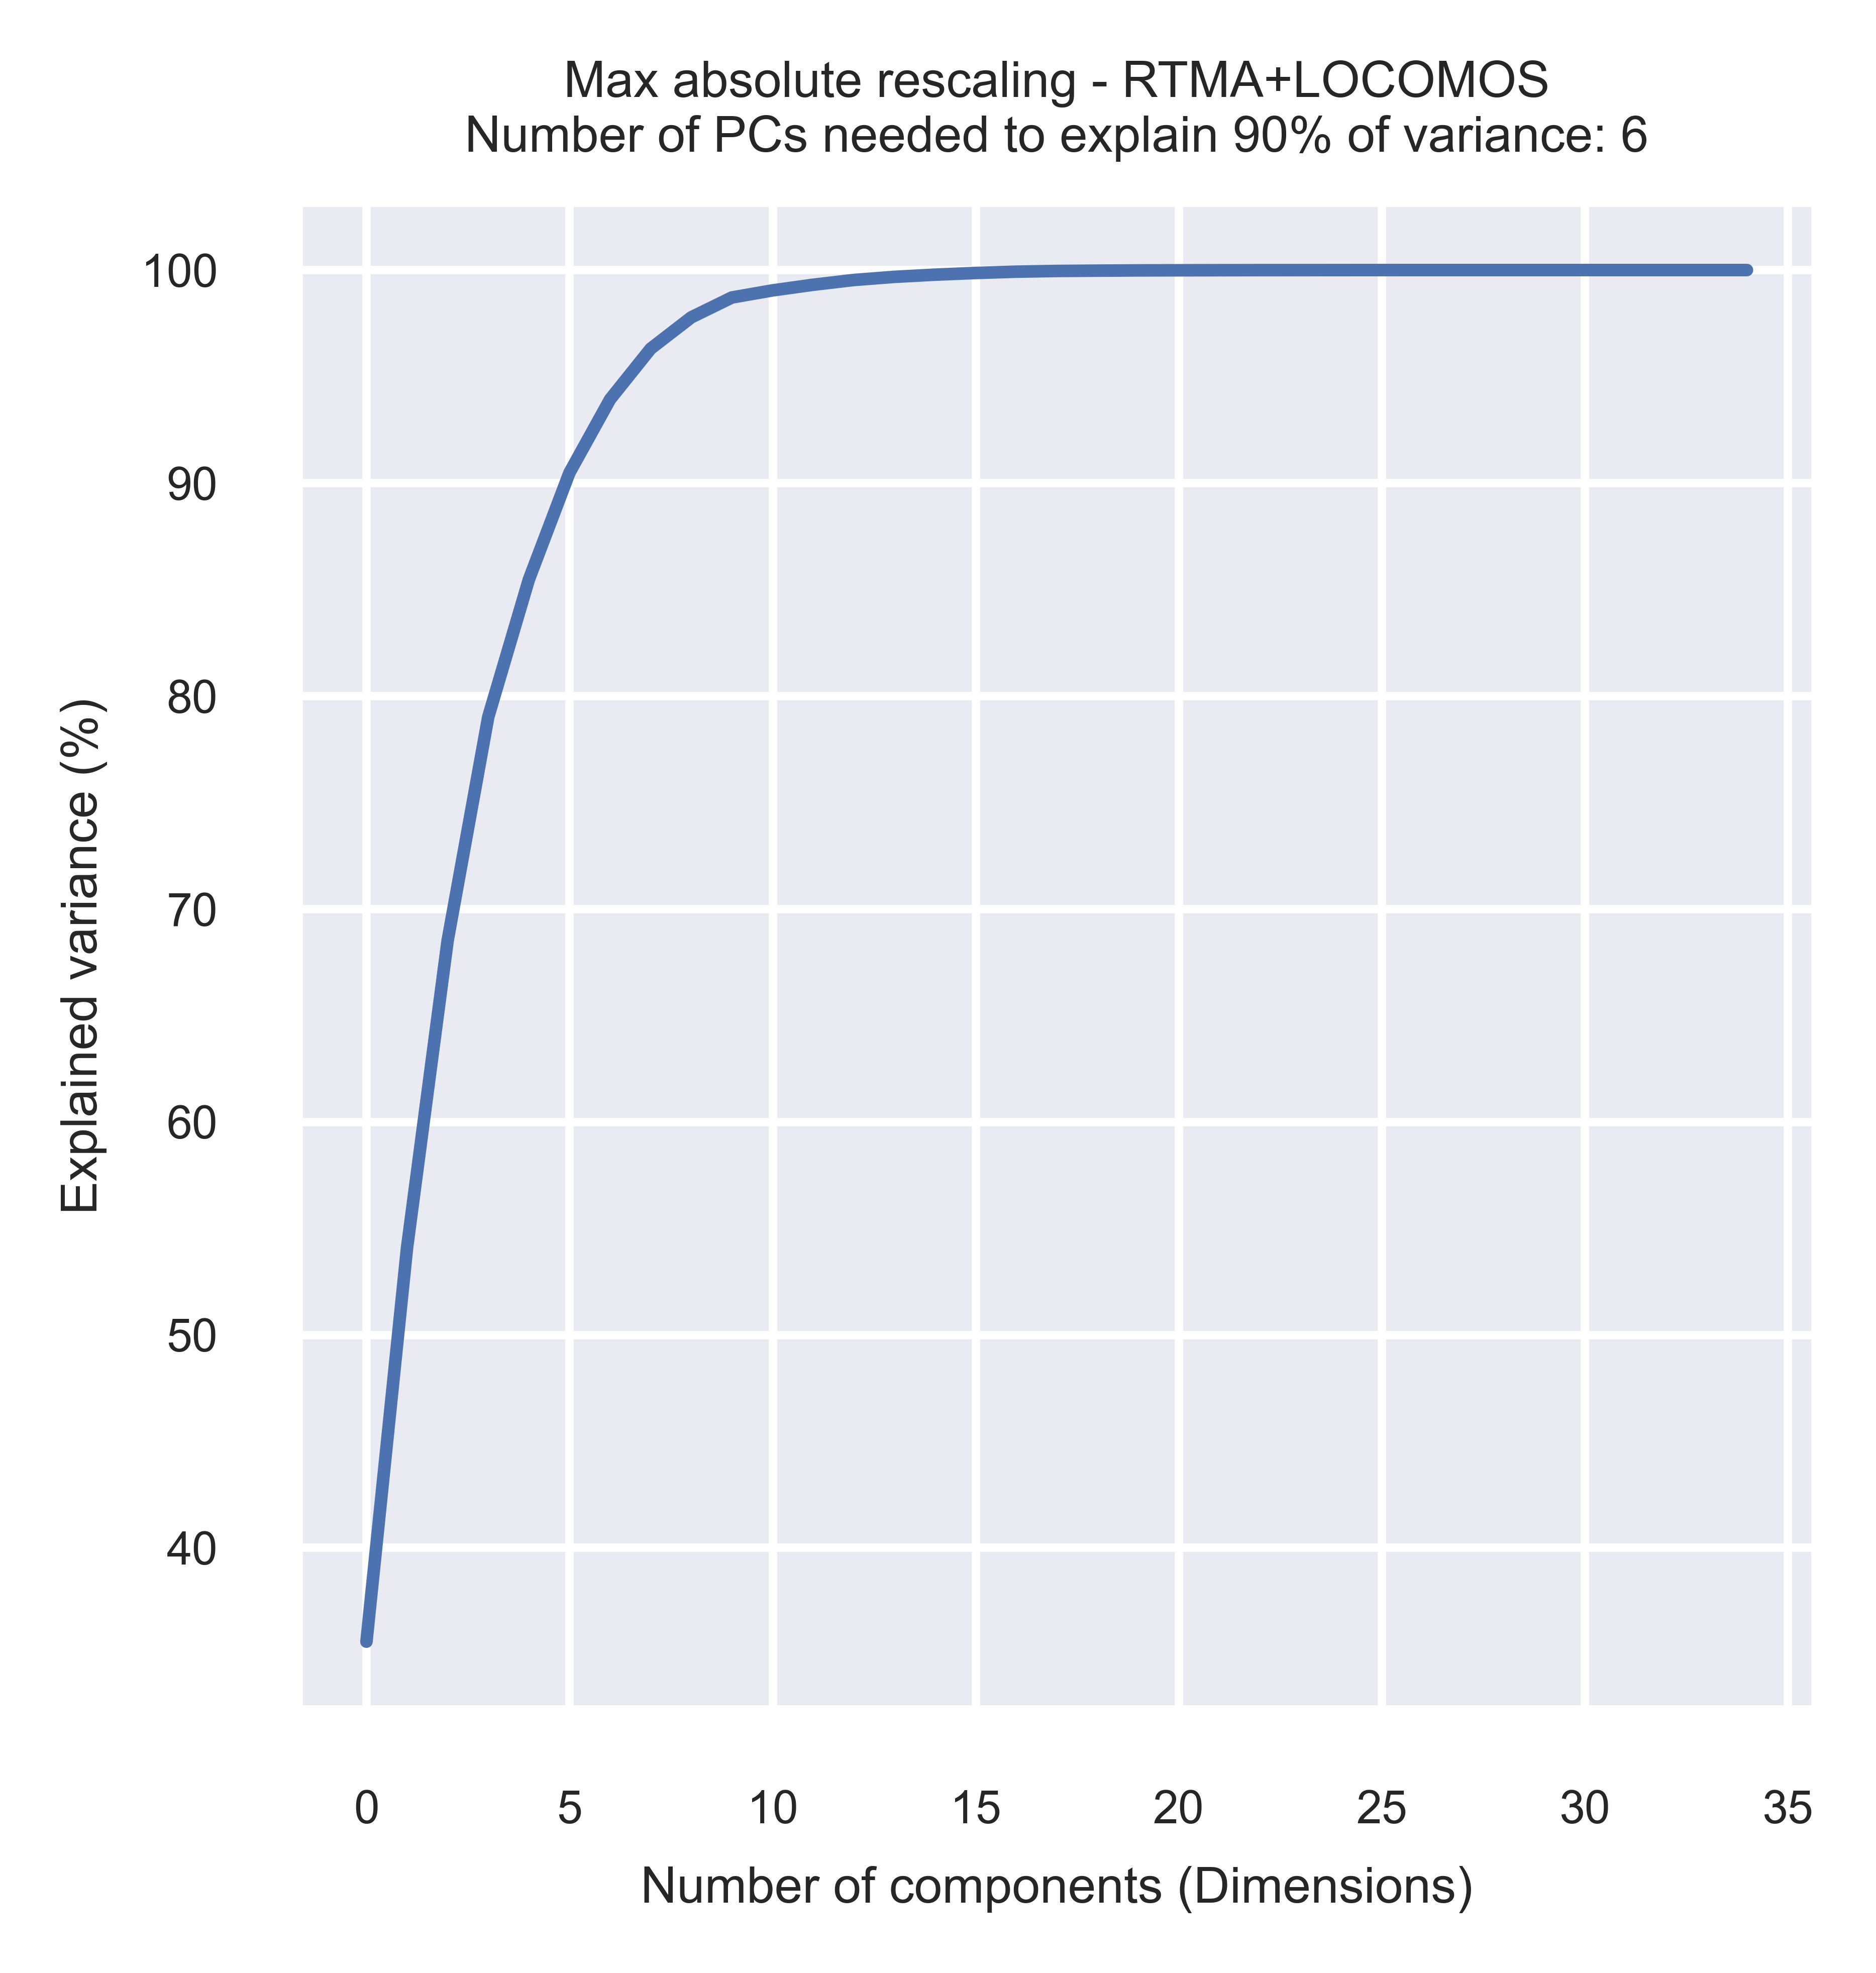

In [9]:
# Apply PCA - max absolute
pca = PCA(n_components=None) # no limit to number of PCAS
pca.fit(dt_max_scaled) # performing PCA

# Retrieve the eigenvalues
#print("Eigenvalues:")
#print(pca.explained_variance_)
#print()

# Return explained variances
#print("Variances (Percentage):")
#print(pca.explained_variance_ratio_ * 100)
#print()

# Plot the scree plot
plt.figure(figsize=(3.25, 3.25), dpi=1200)
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.title('Max absolute rescaling - RTMA+LOCOMOS\nNumber of PCs needed to explain 90% of variance: 6')

# return the number of PCs needed to explain 95% of the variance
pca = PCA(0.90) # set threshold for explained variance to 90%
principalComponents = pca.fit_transform(dt_max_scaled) # perform PCA
print("Number of PCs needed to explain 90% of variance:",  np.shape(principalComponents)[1])

plt.savefig("Scree-LX.png")

#### Min-max feature rescaling

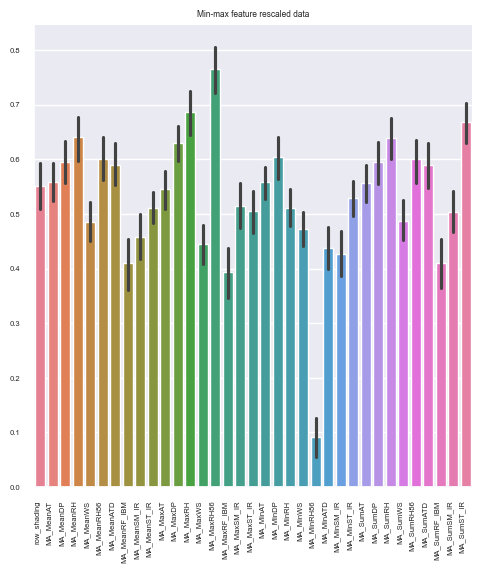

In [10]:
# Copy the data - only the numerical data
dt_min_max_scaled = PCA_df.iloc[:, 7:]
  #Change back to 6: if not using row_shading!!!
    
# Apply normalization techniques
for column in dt_min_max_scaled.columns:
    dt_min_max_scaled[column] = (dt_min_max_scaled[column] - dt_min_max_scaled[column].min()) / (dt_min_max_scaled[column].max() - dt_min_max_scaled[column].min())
    
# View normalized data
#display(dt_min_max_scaled)

# Plot normalized data
sns.set_theme()
sns.set(font_scale=0.5) 
ax = sns.catplot(data=dt_min_max_scaled, kind = 'bar')
ax.set_xticklabels(rotation=90, ha="right")
ax.set(title = 'Min-max feature rescaled data')

number of PCs needed to explain 90% of variance: 7


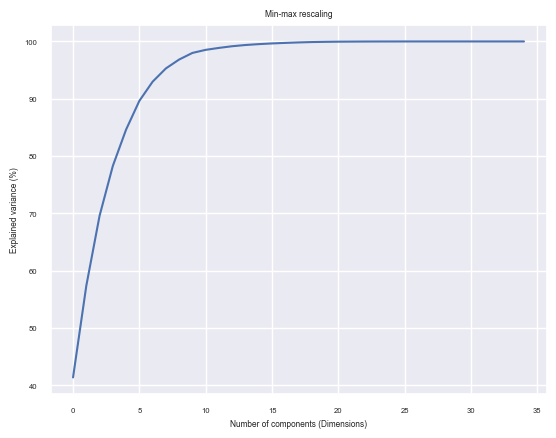

In [11]:
# Apply PCA - max absolute
pca = PCA(n_components=None) # no limit to number of PCAS
pca.fit(dt_min_max_scaled) # performing PCA

# Retrieve the eigenvalues
#print("Eigenvalues:")
#print(pca.explained_variance_)
#print()

# Return explained variances
#print("Variances (Percentage):")
#print(pca.explained_variance_ratio_ * 100)
#print()

# Plot the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.title('Min-max rescaling')

# return the number of PCs needed to explain 95% of the variance
pca = PCA(0.90) # set threshold for explained variance to 90%
principalComponents = pca.fit_transform(dt_min_max_scaled) # perform PCA
print("number of PCs needed to explain 90% of variance:",  np.shape(principalComponents)[1])

#### Z-score rescaling

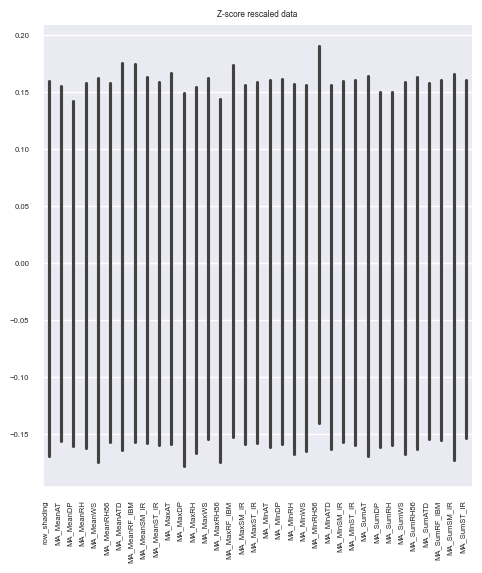

In [12]:
# Copy the data - only the numerical data
dt_z_scaled = PCA_df.iloc[:, 7:]
    
# Apply normalization techniques
for column in dt_z_scaled.columns:
    dt_z_scaled[column] = ((dt_z_scaled[column] - dt_z_scaled[column].mean()) / dt_z_scaled[column].std())
  
# View normalized data   
#display(dt_z_scaled)

# Plot normalized data
sns.set_theme()
sns.set(font_scale=0.5) 
ax = sns.catplot(data=dt_z_scaled, kind = 'bar')
ax.set_xticklabels(rotation=90, ha="right")
ax.set(title = 'Z-score rescaled data')
#plt.savefig("z-score rescaling.png")

number of PCs needed to explain 90% of variance: 7


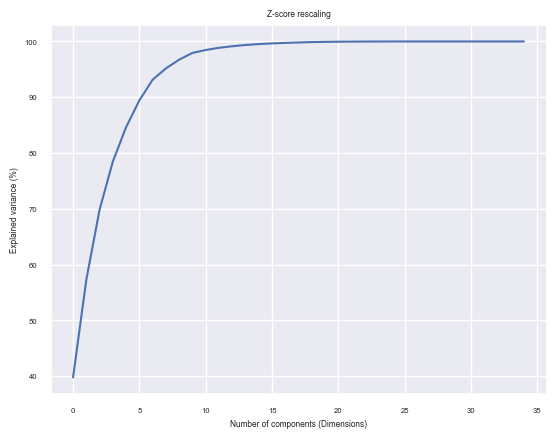

In [13]:
# Apply PCA - max absolute
pca = PCA(n_components=None) # no limit to number of PCAS
pca.fit(dt_z_scaled) # performing PCA

# Retrieve the eigenvalues
#print("Eigenvalues:")
#print(pca.explained_variance_)
#print()

# Return explained variances
#print("Variances (Percentage):")
#print(pca.explained_variance_ratio_ * 100)
#print()

# Plot the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.title('Z-score rescaling')

# return the number of PCs needed to explain 95% of the variance
pca = PCA(0.90) # set threshold for explained variance to 90%
principalComponents = pca.fit_transform(dt_z_scaled) # perform PCA
print("number of PCs needed to explain 90% of variance:",  np.shape(principalComponents)[1])

* max absolute rescaling requires the lowest number of principal components to explain 95% of variance (9)
* therefore, move forward using the max absolute rescaled data set

### Perform PCA to achieve 0.9 explained variance
#### Using best rescaling method (max absolute)

In [14]:
# dictating thresold for number of PCs - 0.90 dictates minimum number of PCs such that 95% of the variance is explained; could also use n = X components if wanted a certain number of components instead of a % explained variance goal
    # Reminder - ratio between potential predictors and data points should be 1:10 (rule of thumb, Dirk Colbry)
pca = PCA(0.90) 
# Calculate principal components - using max absolute rescaled values
principalComponents = pca.fit_transform(dt_max_scaled) 
# Creating column names for principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 
                                                                  'principal component 3', 'principal component 4',
                                                                  'principal component 5', 'principal component 6'])
display(principalDf.head())

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,0.058286,0.355771,0.076817,-0.253237,-0.589425,0.036121
1,0.113248,-0.013674,-0.099592,0.123316,-0.484482,-0.045057
2,0.148736,0.695317,0.200821,-0.393246,-0.307931,0.099219
3,0.082879,0.471094,0.269677,-0.424894,-0.375717,0.087089
4,0.330053,0.088347,0.128628,-0.187635,-0.364406,0.012000


### Visualize PCA loadings

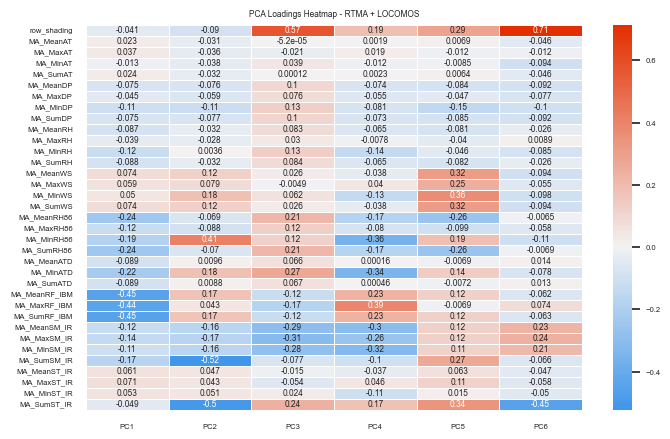

In [15]:
# Extract features names
features = PCA_df.iloc[:, 7:].columns.tolist()

# Extract Loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so features are rows and PCs are columns
    index=features, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Reorder so y axis is clustered by weather variable

desired_order = ['row_shading',
                 'MA_MeanAT', 'MA_MaxAT', 'MA_MinAT', 'MA_SumAT',
                 'MA_MeanDP', 'MA_MaxDP', 'MA_MinDP', 'MA_SumDP',
                 'MA_MeanRH', 'MA_MaxRH', 'MA_MinRH', 'MA_SumRH',
                 'MA_MeanWS', 'MA_MaxWS', 'MA_MinWS', 'MA_SumWS',
                 'MA_MeanRH86', 'MA_MaxRH86', 'MA_MinRH86', 'MA_SumRH86',
                 'MA_MeanATD', 'MA_MinATD', 'MA_SumATD',
                 'MA_MeanRF_IBM', 'MA_MaxRF_IBM', 'MA_SumRF_IBM', 
                 'MA_MeanSM_IR', 'MA_MaxSM_IR', 'MA_MinSM_IR', 'MA_SumSM_IR',
                 'MA_MeanST_IR', 'MA_MaxST_IR', 'MA_MinST_IR', 'MA_SumST_IR']

loadings = loadings.reindex(desired_order)

# Plot Heatmap
plt.figure(figsize=(8, 5))

palette = sns.diverging_palette(255, 15, s=100, as_cmap=True)

sns.heatmap(loadings, annot=True, cmap=palette, center=0, linewidths=0.5)
plt.title("PCA Loadings Heatmap - RTMA + LOCOMOS")

plt.savefig("PCA loadings - LX.png", dpi = 1200)

plt.show()

### Merge PCA data and target data for training and testing data sets

In [15]:
# Merging principal components with targets (binary classification for each data point)
# Changing the array of solutions to a single column data frame
dt_sol = pd.DataFrame(PCA_df.target) 
#display(dt_sol)
#dt_sol.shape

# Merging predictor data (principal components and withheld categorical predictors) with the solutions   
#pc_df = pd.merge(dt_sol, weather_reduced_df.iloc[:, :4], left_index = True, right_index = True)
#pc_df = pd.merge(pc_df, principalDf, left_index = True, right_index = True)
    # for non-categorical data:
pc_df = pd.merge(dt_sol, principalDf, left_index=True, right_index=True)
display(pc_df)
pc_df.shape

,target,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,1,0.058286,0.355771,0.076817,-0.253237,-0.589425,0.036121
1,0,0.113248,-0.013674,-0.099592,0.123316,-0.484482,-0.045057
2,1,0.148736,0.695317,0.200821,-0.393246,-0.307931,0.099219
3,1,0.082879,0.471094,0.269677,-0.424894,-0.375717,0.087089
4,1,0.330053,0.088347,0.128628,-0.187635,-0.364406,0.012000
5,0,0.340537,-0.040167,0.074558,-0.201416,-0.473267,-0.126992
6,0,-0.538729,1.042935,-0.135146,0.053124,-0.157641,-0.037733
7,1,-0.580227,0.975987,0.134261,-0.149409,-0.008777,-0.190064
8,1,-0.548722,0.702212,0.309243,-0.229459,-0.090823,-0.322484
9,1,0.312184,0.004629,0.384416,-0.289140,-0.348311,-0.255714


(147, 7)

### Data splitting (original - no stratification)
* Training: 80%, testing 20%  
* Stratification by apothecia threshold binary

In [40]:
# Split into x and y
xdat = pd.merge(PCA_df.iloc[:, 3], pc_df.loc[:, pc_df.columns != 'target' ], left_index = True, right_index = True) 
ydat = pd.DataFrame(pc_df.loc[:, 'target'])

# Using binary encoding to transform categorical soil type (ML cannot handle categorical)
xdat['soil type'].replace(['sand', 'loamy sand', 'loam'], [0, 1, 2], inplace=True)
display(xdat)

/var/folders/ht/9fl18sfx147g3y41wft40g0c0000gn/T/ipykernel_32021/668946103.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  xdat['soil type'].replace(['sand', 'loamy sand', 'loam'], [0, 1, 2], inplace=True)
/var/folders/ht/9fl18sfx147g3y41wft40g0c0000gn/T/ipykernel_32021/668946103.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

,soil type,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,2,0.058286,0.355771,0.076817,-0.253237,-0.589425,0.036121
1,2,0.113248,-0.013674,-0.099592,0.123316,-0.484482,-0.045057
2,1,0.148736,0.695317,0.200821,-0.393246,-0.307931,0.099219
3,1,0.082879,0.471094,0.269677,-0.424894,-0.375717,0.087089
4,1,0.330053,0.088347,0.128628,-0.187635,-0.364406,0.012000
5,1,0.340537,-0.040167,0.074558,-0.201416,-0.473267,-0.126992
6,2,-0.538729,1.042935,-0.135146,0.053124,-0.157641,-0.037733
7,2,-0.580227,0.975987,0.134261,-0.149409,-0.008777,-0.190064
8,2,-0.548722,0.702212,0.309243,-0.229459,-0.090823,-0.322484
9,2,0.312184,0.004629,0.384416,-0.289140,-0.348311,-0.255714


### Data splitting and stratification

In [41]:
# Independent data still in principalDf data frame
# Dependent data is in dt_sol data frame
# stratifying by dt_sol (0,1)
x_train, x_test, y_train, y_test = train_test_split(xdat, ydat, test_size=0.20, random_state=42, stratify=dt_sol)

In [42]:
# Checking that indexes for data split between x and y match for training and test
print('x training indexes:', x_train.index)
print('y training indexes:', y_train.index)

print('x testing indexes:', x_test.index)
print('y testing indexes:', y_test.index)

x training indexes: Index([123,  32,  39, 131, 139,  49,  50,  52,  40,  97,
       ...
        95, 106,  86,  36,  91, 104,  74, 132,  78, 128],
      dtype='int64', length=117)
y training indexes: Index([123,  32,  39, 131, 139,  49,  50,  52,  40,  97,
       ...
        95, 106,  86,  36,  91, 104,  74, 132,  78, 128],
      dtype='int64', length=117)
x testing indexes: Index([ 84,  24, 108, 109, 146,   8, 134,   4, 142,  51,  80, 116,   2, 114,
        55,  89,  98,  66,  68,  21,  41,  92,  61,  67, 138,  28,  53,  17,
        56,  88],
      dtype='int64')
y testing indexes: Index([ 84,  24, 108, 109, 146,   8, 134,   4, 142,  51,  80, 116,   2, 114,
        55,  89,  98,  66,  68,  21,  41,  92,  61,  67, 138,  28,  53,  17,
        56,  88],
      dtype='int64')


In [43]:
# Checking stratification (equal proportions of positive solutions (target = 1) between train and test)
print(sum(y_train['target'])/len(y_train))
print(sum(y_test['target'])/len(y_test))

0.5641025641025641
0.5666666666666667


### PCA - data load out

In [44]:
x_train.to_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/x_train_LX_PCA.csv', index=False, header=True)
y_train.to_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/y_train_LX_PCA.csv', index=False, header=True)
x_test.to_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/x_test_LX_PCA.csv', index=False, header=True)
y_test.to_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/y_test_LX_PCA.csv', index=False, header=True)